# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [10]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
corpus = newsgroups.data
target = newsgroups.target
target_names = newsgroups.target_names

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

In [14]:
# Construcción de la matriz de términos (TF)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
# Calcular la frecuencia de documentos (DF)
df = (X > 0).sum(axis=0).A1
# Calcular TF-IDF con sklearn
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
# Crear un DataFrame con los términos y sus frecuencias
tfidf = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf,
    columns=tfidf_vectorizer.get_feature_names_out()
)
# Añadir la columna de etiquetas
tfidf['target'] = target
# Añadir la columna de nombres de categorías
tfidf['target_names'] = [target_names[i] for i in target]

print(tfidf.head())

   00  000  0000  00000  000000  00000000  0000000004  00000000b  00000001  \
0   0    0     0      0       0         0           0          0         0   
1   0    0     0      0       0         0           0          0         0   
2   0    0     0      0       0         0           0          0         0   
3   0    0     0      0       0         0           0          0         0   
4   0    0     0      0       0         0           0          0         0   

   00000001b  ...  zzvsi  zzy_3w  zzz  zzzoh  zzzzzz  zzzzzzt  ³ation  ýé  \
0          0  ...      0       0    0      0       0        0       0   0   
1          0  ...      0       0    0      0       0        0       0   0   
2          0  ...      0       0    0      0       0        0       0   0   
3          0  ...      0       0    0      0       0        0       0   0   
4          0  ...      0       0    0      0       0        0       0   0   

   ÿhooked              target_names  
0        0          rec.sport

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

## Crear el vector consulta

In [16]:
query = "jersey"

In [17]:
query_vect = vectorizer.transform([query])
print(query_vect)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1 stored elements and shape (1, 134410)>
  Coords	Values
  (0, 68989)	1


### Calcular la similitud coseno

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
 # dist arreglo de similitudes de la consulta y cada documento entre [0-1]
dist = cosine_similarity(query_vect, X).flatten()
print(dist)

[0.05292561 0.         0.         ... 0.         0.         0.        ]


### Generar el ranking y mostrar tabla

In [21]:
top_k = 50

# Ranking de indices debe ser una lista de enteros
ranking_indices = dist.argsort()[::-1] # argsort devuelve índices de menor a mayor y con [::1] invertimos ese orden

# Construcción del DataFrame
resultados = pd.DataFrame({
    'Ranking': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices[:top_k]],
    'Similitud coseno': [dist[i] for i in ranking_indices[:top_k]],
    #'Categoría': [target_names[target[i]] for i in ranking_indices[:top_k]] #
})

print(resultados)

    Ranking                                     Documento  Similitud coseno
0         1         $200 in Glassboro, New Jersey  :( ...          0.447214
1         2  \tDon't forget Paul Ysebaert, ex-Devil.  ...          0.218218
2         3   Boston                           2 2 0--...          0.209083
3         4   cd's for sale:  1. jon bon jovi - new je...          0.176777
4         5   Does anyone here know where I can find a...          0.174078
5         6   HELP!  I'm stuck here at a computer in N...          0.171499
6         7   Philadelphia                     1 1 2 1...          0.167705
7         8   s:   I have a 1991 Toyota Camry Deluxe f...          0.145865
8         9    I had heard(perhaps incorrectly) that w...          0.142857
9        10    Not to mention the thread about selling...          0.138675
10       11   Thanks to all who replied to my initial ...          0.124035
11       12   \tI just went through this mess in New J...          0.123091
12       13 

## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

### Libreria BM25

In [22]:
from rank_bm25 import BM25Okapi

# Crear el modelo BM25
bm25 = BM25Okapi(corpus)
# Scores BM25 para la consulta
scores_bm25 = bm25.get_scores(query)
# Ranking de índices BM25 
ranking_indices_bm25 = scores_bm25.argsort()[::-1]  # Ordenar de mayor a menor
# Construcción del DataFrame BM25
resultados_bm25 = pd.DataFrame({
    'Ranking BM25': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices_bm25[:top_k]],
    'Score BM25': [scores_bm25[i] for i in ranking_indices_bm25[:top_k]]
})
print(resultados_bm25)


    Ranking BM25                                     Documento  Score BM25
0              1    Well, I used to get mad, and either try...    9.003147
1              2   #[reply to frank@D012S658.uucp (Frank O'...    9.003011
2              3   This discussion on "objective" seems to ...    8.995510
3              4     If you only do read/print then there i...    8.969370
4              5        The problem is, your use of the wor...    8.959503
5              6            I don't mean to sound disrespec...    8.957637
6              7     Atoms are not objective.  They aren't ...    8.957389
7              8   There is a cartridge capping upgrade for...    8.950542
8              9    Now, take a good look at at, an tell me...    8.939102
9             10   There are many people want to buy my Kod...    8.937240
10            11   4/15/93 1242  Turkey sends light weapons...    8.932973
11            12      I second that suggestion.  Although I...    8.924366
12            13   It dep

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

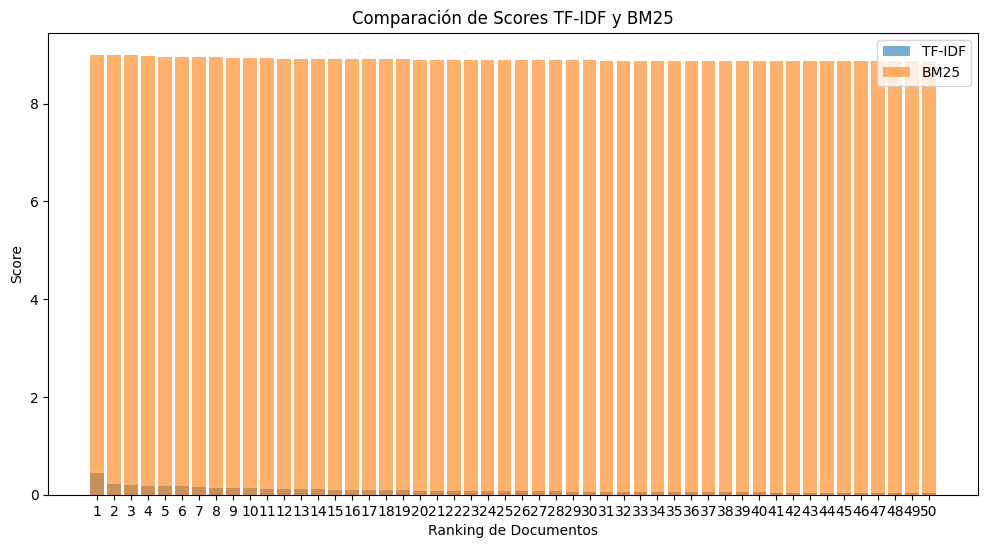

In [23]:
# Gráfico de barras para visualizar los scores por cada documento tfidf y bm25
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(resultados['Ranking'], resultados['Similitud coseno'], label='TF-IDF', alpha=0.6)
plt.bar(resultados_bm25['Ranking BM25'], resultados_bm25['Score BM25'], label='BM25', alpha=0.6)
plt.xlabel('Ranking de Documentos')
plt.ylabel('Score')
plt.title('Comparación de Scores TF-IDF y BM25')
plt.xticks(range(1, top_k + 1))
plt.legend()
plt.show()

In [26]:
# ¿Qué método es mejor?
# La elección entre TF-IDF y BM25 depende del contexto y de la naturaleza de los datos.
# TF-IDF es más adecuado para tareas donde la frecuencia de términos es importante,
# mientras que BM25 es más robusto para consultas con términos comunes y es menos sensible a la longitud del documento.
# BM25 tiende a manejar mejor la relevancia de los documentos en función de la longitud y la frecuencia de términos,
# lo que lo hace más efectivo en muchos casos de búsqueda de información.
# En general, BM25 es considerado un modelo más avanzado y efectivo para la recuperación de información,
# especialmente en grandes colecciones de documentos.

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [27]:
# Elección de una consulta y definición de que documento es relevante
consulta = "computer graphics"
# Definir el documento relevante
documento_relevante = "graphics and computer vision"
# Calcular la similitud coseno para la consulta
consulta_vect = vectorizer.transform([consulta])
# Calcular la similitud coseno entre la consulta y los documentos
dist_consulta = cosine_similarity(consulta_vect, X).flatten()
# Ranking de índices para la consulta
ranking_indices_consulta = dist_consulta.argsort()[::-1]
# Construcción del DataFrame para la consulta
resultados_consulta = pd.DataFrame({
    'Ranking': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices_consulta[:top_k]],
    'Similitud coseno': [dist_consulta[i] for i in ranking_indices_consulta[:top_k]],
})
print(resultados_consulta)

    Ranking                                     Documento  Similitud coseno
0         1   Technion - Israel Institute of Technolog...          0.463428
1         2    My package is based on several articles...          0.425195
2         3   EUROPEAN COMPUTER RESEARCH CENTRE  Resea...          0.410997
3         4   \tYes, that's known as "Bresenhams Run L...          0.377964
4         5              subscribe comp.graphics quit ...          0.353553
5         6   Graeme> \tYes, that's known as "Bresenha...          0.317721
6         7    This sounds wonderful, but it seems no ...          0.309426
7         8    I've been given the sites of some excel...          0.303046
8         9   I'm currently looking for a viewer for C...          0.301511
9        10     Point your gopher client at merlot.wel...          0.297896
10       11    I'm also interested in info both public...          0.287213
11       12   Within the next several months I'll be l...          0.286770
12       13 

In [29]:
# Evaluación de presición para los rankings generados por TF-IDF y BM25
from sklearn.metrics import precision_score
def precision_at_k(ranking, relevant_docs, k):
    """
    Calcula la precisión en el top-k de un ranking dado.
    
    :param ranking: Lista de documentos ordenados por relevancia.
    :param relevant_docs: Lista de documentos relevantes.
    :param k: Número de documentos a considerar en el ranking.
    :return: Precisión en el top-k.
    """
    if k > len(ranking):
        k = len(ranking)
    
    retrieved_docs = set(ranking[:k])
    relevant_docs_set = set(relevant_docs)
    
    true_positives = len(retrieved_docs.intersection(relevant_docs_set))
    
    return true_positives / k
# resultados
relevantes = [i for i, doc in enumerate(corpus) if documento_relevante in doc]
precision_tfidf = precision_at_k(resultados['Documento'], relevantes, top_k)
precision_bm25 = precision_at_k(resultados_bm25['Documento'], relevantes, top_k)
print(f"Precisión en el top-{top_k} para TF-IDF: {precision_tfidf:.4f}")
print(f"Precisión en el top-{top_k} para BM25: {precision_bm25:.4f}")

Precisión en el top-50 para TF-IDF: 0.0000
Precisión en el top-50 para BM25: 0.0000
